# **Check Avaibility of GPU**

In [ ]:
import torch

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# **Installation of packages**

In [ ]:
pip install datasets==1.0.2

In [ ]:
pip install transformers

     |████████████████████████████████| 2.1MB 18.0MB/s 
     |████████████████████████████████| 3.2MB 38.2MB/s 
     |████████████████████████████████| 890kB 60.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=303821f13737b4d05fbd9246d0a41491ebf2766d5fbc54a40f82d0901d0ba074
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
pip install pyrouge

     |████████████████████████████████| 61kB 8.4MB/s 
  Created wheel for pyrouge: filename=pyrouge-0.1.3-cp37-none-any.whl size=191613 sha256=501a6866b5ff11ffc302ac9b537abee8df7d3995613f246598b5f78628a03ef5
  Stored in directory: /root/.cache/pip/wheels/75/d3/0c/e5b04e15b6b87c42e980de3931d2686e14d36e045058983599
Successfully built pyrouge


In [ ]:
!pip install git-python==1.0.3
!pip install sacrebleu==1.4.12
!pip install rouge_score

     |████████████████████████████████| 163kB 20.1MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 17.1MB 198kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import datasets
import transformers


# **Data Preprocessing and Tokenization Amazon Reviews**

In [ ]:
from transformers import TrainingArguments,Trainer
from dataclasses import dataclass, field
from typing import Optional
from transformers.file_utils import add_start_docstrings
import logging

In [ ]:
import pandas as pd
import io
df = pd.read_csv("/content/drive/MyDrive/SGP sem 6/reviews.csv") #Read dataset

In [ ]:
df.drop(columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator','HelpfulnessDenominator', 'Score', 'Time'],axis=1,inplace=True)
df = df.dropna()
print("Data size", len(df))
df.head()

Data size 568427


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df['Text'][6]

"This saltwater taffy had great flavors and was very soft and chewy.  Each candy was individually wrapped well.  None of the candies were stuck together, which did happen in the expensive version, Fralinger's.  Would highly recommend this candy!  I served it at a beach-themed party and everyone loved it!"

In [ ]:
from datasets import Dataset
train_data=Dataset.from_pandas(df[:550000])
val_data=Dataset.from_pandas(df[550000:555000])
test_data=Dataset.from_pandas(df[556000:558000])

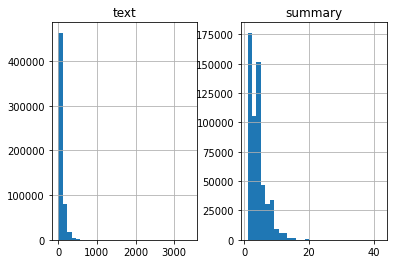

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['Text']:
      text_word_count.append(len(i.split()))

for i in df['Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
#Made from the core of GPT2 using byte level encoding
from transformers import BartTokenizerFast

tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-base")
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

In [ ]:
encoder_max_length=40
decoder_max_length=6

batch_size=256 
#change to batch["Text"] and batch["Summary"] for amazon review dataset
def process_data_to_model_inputs(batch):
  #tokenizer() will convert the text into tokens and padding for combining the tokens
  inputs = tokenizer.batch_encode_plus(batch["Text"], padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer.batch_encode_plus(batch["Summary"], padding="max_length", truncation=True, max_length=decoder_max_length)
  #These are the tokens : input ids, attention mask etc.
  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  #batch["decoder_input_ids"] = outputs.input_ids
  #batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

train_data = train_data.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["Text", "Summary"]
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)

val_data = val_data.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["Text", "Summary"]
)
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)

In [ ]:
train_data

Dataset(features: {'__index_level_0__': Value(dtype='int64', id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 550000)

In [ ]:
val_data

Dataset(features: {'__index_level_0__': Value(dtype='int64', id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 5000)

# **Using Bart**

In [ ]:
from transformers import BartForConditionalGeneration, BartConfig,BartModel

bart_premodel = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [ ]:
#Change the configurations for more fine tuning

configuration = BartConfig()

#Use this for some cases 
#bart_pre1_optional = BartModel(configuration)

# set special tokens
bart_premodel.config.decoder_start_token_id = tokenizer.bos_token_id                                             
bart_premodel.config.eos_token_id = tokenizer.eos_token_id

#bart_premodel.config.activation_function = 'gelu'
# sensible parameters for beam search
# set decoding params                               
bart_premodel.config.max_length = 40 
#bart_premodel.config.min_length = 30
bart_premodel.config.early_stopping = True
bart_premodel.config.no_repeat_ngram_size = 3
bart_premodel.config.length_penalty = 2.0
bart_premodel.config.num_beams = 4
bart_premodel.config.vocab_size = configuration.vocab_size
bart_premodel.encoder_layerdrop = 0.2

# **Seq2Seq Trainer**

In [ ]:
from typing import Any, Dict, List, Optional, Tuple, Union

import torch
from packaging import version
from torch import nn
from torch.utils.data.dataset import Dataset

from transformers.trainer import Trainer
from transformers.trainer_utils import PredictionOutput
from transformers.utils import logging


if version.parse(torch.__version__) >= version.parse("1.6"):
    from torch.cuda.amp import autocast


logger = logging.get_logger(__name__)


class Seq2SeqTrainer(Trainer):
    def evaluate(
        self,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
        max_length: Optional[int] = None,
        num_beams: Optional[int] = None,
    ) -> Dict[str, float]:
        """
        Run evaluation and returns metrics.
        The calling script will be responsible for providing a method to compute metrics, as they are task-dependent
        (pass it to the init :obj:`compute_metrics` argument).
        You can also subclass and override this method to inject custom behavior.
        Args:
            eval_dataset (:obj:`Dataset`, `optional`):
                Pass a dataset if you wish to override :obj:`self.eval_dataset`. If it is an :obj:`datasets.Dataset`,
                columns not accepted by the ``model.forward()`` method are automatically removed. It must implement the
                :obj:`__len__` method.
            ignore_keys (:obj:`List[str]`, `optional`):
                A list of keys in the output of your model (if it is a dictionary) that should be ignored when
                gathering predictions.
            metric_key_prefix (:obj:`str`, `optional`, defaults to :obj:`"eval"`):
                An optional prefix to be used as the metrics key prefix. For example the metrics "bleu" will be named
                "eval_bleu" if the prefix is ``"eval"`` (default)
            max_length (:obj:`int`, `optional`):
                The maximum target length to use when predicting with the generate method.
            num_beams (:obj:`int`, `optional`):
                Number of beams for beam search that will be used when predicting with the generate method. 1 means no
                beam search.
        Returns:
            A dictionary containing the evaluation loss and the potential metrics computed from the predictions. The
            dictionary also contains the epoch number which comes from the training state.
        """
        self._max_length = max_length
        self._num_beams = num_beams
        return super().evaluate(eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)

    def predict(
        self,
        test_dataset: Dataset,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
        max_length: Optional[int] = None,
        num_beams: Optional[int] = None,
    ) -> PredictionOutput:
        """
        Run prediction and returns predictions and potential metrics.
        Depending on the dataset and your use case, your test dataset may contain labels. In that case, this method
        will also return metrics, like in :obj:`evaluate()`.
        Args:
            test_dataset (:obj:`Dataset`):
                Dataset to run the predictions on. If it is an :obj:`datasets.Dataset`, columns not accepted by the
                ``model.forward()`` method are automatically removed. Has to implement the method :obj:`__len__`
            ignore_keys (:obj:`List[str]`, `optional`):
                A list of keys in the output of your model (if it is a dictionary) that should be ignored when
                gathering predictions.
            metric_key_prefix (:obj:`str`, `optional`, defaults to :obj:`"eval"`):
                An optional prefix to be used as the metrics key prefix. For example the metrics "bleu" will be named
                "eval_bleu" if the prefix is ``"eval"`` (default)
            max_length (:obj:`int`, `optional`):
                The maximum target length to use when predicting with the generate method.
            num_beams (:obj:`int`, `optional`):
                Number of beams for beam search that will be used when predicting with the generate method. 1 means no
                beam search.
        .. note::
            If your predictions or labels have different sequence lengths (for instance because you're doing dynamic
            padding in a token classification task) the predictions will be padded (on the right) to allow for
            concatenation into one array. The padding index is -100.
        Returns: `NamedTuple` A namedtuple with the following keys:
            - predictions (:obj:`np.ndarray`): The predictions on :obj:`test_dataset`.
            - label_ids (:obj:`np.ndarray`, `optional`): The labels (if the dataset contained some).
            - metrics (:obj:`Dict[str, float]`, `optional`): The potential dictionary of metrics (if the dataset
              contained labels).
        """
        self._max_length = max_length
        self._num_beams = num_beams
        return super().predict(test_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)

    def prediction_step(
        self,
        model: nn.Module,
        inputs: Dict[str, Union[torch.Tensor, Any]],
        prediction_loss_only: bool,
        ignore_keys: Optional[List[str]] = None,
    ) -> Tuple[Optional[float], Optional[torch.Tensor], Optional[torch.Tensor]]:
        """
        Perform an evaluation step on :obj:`model` using obj:`inputs`.
        Subclass and override to inject custom behavior.
        Args:
            model (:obj:`nn.Module`):
                The model to evaluate.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.
            prediction_loss_only (:obj:`bool`):
                Whether or not to return the loss only.
        Return:
            Tuple[Optional[float], Optional[torch.Tensor], Optional[torch.Tensor]]: A tuple with the loss, logits and
            labels (each being optional).
        """

        if not self.args.predict_with_generate or prediction_loss_only:
            return super().prediction_step(
                model, inputs, prediction_loss_only=prediction_loss_only, ignore_keys=ignore_keys
            )

        has_labels = "labels" in inputs
        inputs = self._prepare_inputs(inputs)

        gen_kwargs = {
            "max_length": self._max_length if self._max_length is not None else self.model.config.max_length,
            "num_beams": self._num_beams if self._num_beams is not None else self.model.config.num_beams,
        }

        generated_tokens = self.model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            **gen_kwargs,
        )
        # in case the batch is shorter than max length, the output should be padded
        if generated_tokens.shape[-1] < gen_kwargs["max_length"]:
            generated_tokens = self._pad_tensors_to_max_len(generated_tokens, gen_kwargs["max_length"])

        with torch.no_grad():
            if self.use_amp:
                with autocast():
                    outputs = model(**inputs)
            else:
                outputs = model(**inputs)
            if has_labels:
                if self.label_smoother is not None:
                    loss = self.label_smoother(outputs, inputs["labels"]).mean().detach()
                else:
                    loss = (outputs["loss"] if isinstance(outputs, dict) else outputs[0]).mean().detach()
            else:
                loss = None

        if self.args.prediction_loss_only:
            return (loss, None, None)

        labels = inputs["labels"]
        if labels.shape[-1] < gen_kwargs["max_length"]:
            labels = self._pad_tensors_to_max_len(labels, gen_kwargs["max_length"])

        return (loss, generated_tokens, labels)

    def _pad_tensors_to_max_len(self, tensor, max_length):
        if self.tokenizer is None:
            raise ValueError(
                f"Tensor need to be padded to `max_length={max_length}` but no tokenzier was passed when creating "
                "this `Trainer`. Make sure to create your `Trainer` with the appropriate tokenizer."
            )
        # If PAD token is not defined at least EOS token has to be defined
        pad_token_id = (
            self.tokenizer.pad_token_id if self.tokenizer.pad_token_id is not None else self.tokenizer.eos_token_id
        )

        padded_tensor = pad_token_id * torch.ones(
            (tensor.shape[0], max_length), dtype=tensor.dtype, device=tensor.device
        )
        padded_tensor[:, : tensor.shape[-1]] = tensor
        return padded_tensor

In [ ]:
@dataclass
class Seq2SeqTrainingArguments(TrainingArguments):
    """
    sortish_sampler (:obj:`bool`, `optional`, defaults to :obj:`False`):
        Whether to use a `sortish sampler` or not. Only possible if the underlying datasets are `Seq2SeqDataset` for
        now but will become generally available in the near future.
        It sorts the inputs according to lengths in order to minimize the padding size, with a bit of randomness for
        the training set.
    predict_with_generate (:obj:`bool`, `optional`, defaults to :obj:`False`):
        Whether to use generate to calculate generative metrics (ROUGE, BLEU).
    """

    sortish_sampler: bool = field(default=False, metadata={"help": "Whether to use SortishSampler or not."})

    predict_with_generate: bool = field(
        default=False, metadata={"help": "Whether to use generate to calculate generative metrics (ROUGE, BLEU)."}
    )

    label_smoothing: Optional[float] = field(
        default=0.0, metadata={"help": "The label smoothing epsilon to apply (if not zero)."}
    )

    adafactor: bool = field(default=False, metadata={"help": "whether to use adafactor"})

    encoder_layerdrop: Optional[float] = field(
        default=0.2, metadata={"help": "Encoder layer dropout probability. Goes into model.config."}
    )

#Layer drop rate as 0.2 for regularization
    decoder_layerdrop: Optional[float] = field(
        default=0.2, metadata={"help": "Decoder layer dropout probability. Goes into model.config."}
    )

    dropout: Optional[float] = field(default=None, metadata={"help": "Dropout probability. Goes into model.config."})
    
    attention_dropout: Optional[float] = field(
        default=None, metadata={"help": "Attention dropout probability. Goes into model.config."}
    )

    lr_scheduler: Optional[str] = field(
        default="linear", metadata={"help": f"Which lr scheduler to use."}
    )

# **Fine Tuning**

In [ ]:
import datasets
# load rouge for validation
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    decoded_pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    #labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    if data_args.ignore_pad_token_for_loss:
            # Replace -100 in the labels as we can't decode them.
            labels_ids = np.where(labels_ids != -100, labels_ids, tokenizer.pad_token_id)

    decoded_label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=decoded_pred_str, references=decoded_label_str, use_stemmer=True)
    rouge_output = {key: value.mid.fmeasure * 100 for key, value in rouge_output.items()}

    '''
    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }
    '''

    #OR

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in pred_ids]
    rouge_output["gen_len"] = np.mean(prediction_lens)
    rouge_output = {k: round(v, 4) for k, v in result.items()}
    print(rouge_output)
    return rouge_output





In [ ]:
#import transformers.training_args

In [ ]:
#lr is 5e-5 by default
# set training arguments - these params are not really tuned, feel free to change
training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    #evaluate_during_training=True,
    do_train=True,
    do_eval=True,
    logging_steps=1000,  #1000 for full training
    save_steps=1000, #1000 for full training  
    eval_steps=1500,  #1500 for full training
    warmup_steps=1000, #1000 for full training
    #max_steps=11, # delete for full training
    overwrite_output_dir=True,
    save_total_limit=1,
    weight_decay = 0.01,
    fp16=True, 
    num_train_epochs = 16, #16 for full
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=bart_premodel,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
)


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step,Training Loss


Step,Training Loss


# **Fine Tuned Model**

In [ ]:
#We just copy the checkpoint to our drive and then use that checkpoint in from_pretrained() so that we dont have to execute the model again.
!cp -r /content/checkpoint-20000 "/content/drive/MyDrive/SGP sem 6"

In [ ]:
#torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.empty_cache()

In [ ]:
import datasets
from transformers import BartTokenizerFast, EncoderDecoderModel,BartForConditionalGeneration

tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("/content/drive/MyDrive/SGP sem 6/checkpoint-8400")
model.to("cuda")
batch_size = 4 #Change to 8000 for full training

#test_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="test")

# only use 16 training examples for notebook - DELETE LINE FOR FULL TRAINING
#test_data = test_data.select(range(16))


# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["Text"], padding="max_length", truncation=True, max_length=1024, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch



results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["Text"])

pred_str = results["pred"]
label_str = results["Summary"]

#rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
rouge_output = rouge.compute(predictions=pred_str, references=label_str, use_stemmer=True)
# Extract a few results from ROUGE
rouge_output = {key: value.mid.fmeasure * 100 for key, value in rouge_output.items()}

print(rouge_output)


{'rouge1': 20.928526000272512, 'rougeL': 20.639762918582967}


In [ ]:
pred_str[3]

'Not the real thing'

In [ ]:
label_str[3]

'This is not the right Lavazza coffee'

In [ ]:
test_data['Text'][3]

'What I received is not the real Lavazza coffee and I should know since I am from Italy and from the same area where this coffee is produced. When I opened the can, there was no coffee smell and when I made a cup it did not taste like the real thing. In fact, it tasted terrible. I usually buy the product from the local Italian food store and I can assure you what I received from Amazon was not the same thing. I am very disappointed and I will be very careful before I buy any food items from Amazon in the future since, apparently, they cannot be returned.'

# **Rouge Score**

In [ ]:
#Reference from : https://github.com/Arjun-Mota/hotel_reviews_summarization_with_huggingface_transformers/blob/master/pyrouge.py

from __future__ import division
from itertools import chain


def get_unigram_count(tokens):
    count_dict = dict()
    for t in tokens:
        if t in count_dict:
            count_dict[t] += 1
        else:
            count_dict[t] = 1

    return count_dict


class Rouge:
    beta = 1

    @staticmethod
    def my_lcs_grid(x, y):
        n = len(x)
        m = len(y)

        table = [[0 for i in range(m + 1)] for j in range(n + 1)]

        for j in range(m + 1):
            for i in range(n + 1):
                if i == 0 or j == 0:
                    cell = (0, 'e')
                elif x[i - 1] == y[j - 1]:
                    cell = (table[i - 1][j - 1][0] + 1, '\\')
                else:
                    over = table[i - 1][j][0]
                    left = table[i][j - 1][0]

                    if left < over:
                        cell = (over, '^')
                    else:
                        cell = (left, '<')

                table[i][j] = cell

        return table

    @staticmethod
    def my_lcs(x, y, mask_x):
        table = Rouge.my_lcs_grid(x, y)
        i = len(x)
        j = len(y)

        while i > 0 and j > 0:
            move = table[i][j][1]
            if move == '\\':
                mask_x[i - 1] = 1
                i -= 1
                j -= 1
            elif move == '^':
                i -= 1
            elif move == '<':
                j -= 1

        return mask_x

    @staticmethod
    def rouge_l(cand_sents, ref_sents):
        lcs_scores = 0.0
        cand_unigrams = get_unigram_count(chain(*cand_sents))
        ref_unigrams = get_unigram_count(chain(*ref_sents))
        for cand_sent in cand_sents:
            cand_token_mask = [0 for t in cand_sent]
            cand_len = len(cand_sent)
            for ref_sent in ref_sents:
                # aligns = []
                # Rouge.lcs(ref_sent, cand_sent, aligns)
                Rouge.my_lcs(cand_sent, ref_sent, cand_token_mask)

                # for i in aligns:
                #     ref_token_mask[i] = 1
            # lcs = []
            cur_lcs_score = 0.0
            for i in range(cand_len):
                if cand_token_mask[i]:
                    token = cand_sent[i]
                    if cand_unigrams[token] > 0 and ref_unigrams[token] > 0:
                        cand_unigrams[token] -= 1
                        ref_unigrams[token] -= 1
                        cur_lcs_score += 1

                        # lcs.append(token)

            # print ' '.join(lcs)

            lcs_scores += cur_lcs_score

        # print "lcs_scores: %d" % lcs_scores
        ref_words_count = sum(len(s) for s in ref_sents)
        # print "ref_words_count: %d" % ref_words_count
        cand_words_count = sum(len(s) for s in cand_sents)
        # print "cand_words_count: %d" % cand_words_count

        precision = lcs_scores / cand_words_count
        recall = lcs_scores / ref_words_count
        f_score = (1 + Rouge.beta ** 2) * precision * recall / (recall +
                                                                Rouge.beta ** 2 * precision + 1e-7) + 1e-6  # prevent underflow
        return precision, recall, f_score

    # @staticmethod
    # def rouge_2(cand_sents, ref_sents):
    #     cand_bigram_counts = get_bigram_counts(cand_sents)
    #     ref_bigram_counts = get_bigram_counts(ref_sents)


if __name__ == '__main__':
    r = Rouge()
    # A simple eample of how rouge can be calculated
    print(r.rouge_l([[1, 7, 6, 7, 5], [0, 2, 8, 3, 5]],
                    [[1, 2, 3, 4, 5], [3, 9, 5]]))

    # A more practical example of how it can be used for summary evaluation
    system_generated_summary = " The Kyrgyz President pushed through the law requiring the use of ink during the upcoming Parliamentary and Presidential elections In an effort to live up to its reputation in the 1990s as an island of democracy. The use of ink is one part of a general effort to show commitment towards more open elections. improper use of this type of ink can cause additional problems as the elections in Afghanistan showed. The use of ink and readers by itself is not a panacea for election ills."
    manual_summmary = " The use of invisible ink and ultraviolet readers in the elections of the Kyrgyz Republic which is a small, mountainous state of the former Soviet republic, causing both worries and guarded optimism among different sectors of the population. Though the actual technology behind the ink is not complicated, the presence of ultraviolet light (of the kind used to verify money) causes the ink to glow with a neon yellow light. But, this use of the new technology has caused a lot of problems. "

    print(r.rouge_l([system_generated_summary], [manual_summmary]))

(0.5, 0.625, 0.5555565061728439)
(0.4472049689440994, 0.44081632653061226, 0.4439886170118432)


# **Evaluation**

In [ ]:
import imp
pyrouge = imp.new_module('pyrouge')

bart_prec = []
bart_rec = []
bart_f1 = []

ro = Rouge()

for location in range(2000):
  [p,r,f] = ro.rouge_l(pred_str[location], label_str[location])
  bart_prec.append(p)
  bart_rec.append(r)
  bart_f1.append(f)

bart_precision = sum(bart_prec)/len(bart_prec)
bart_recall = sum(bart_rec)/len(bart_rec)
bart_f1_score = sum(bart_f1)/len(bart_f1)

print('*'*40+' BART SUMMARIZATION SCORE '+'*'*40)
print('PRECISION | RECALL | F1 SCORE')
print(str(round(bart_precision, 4))+'\t   ', str(round(bart_recall, 4))+'\t', str(round(bart_f1_score, 4)))
print('-'*80)

**************************************** BART SUMMARIZATION SCORE ****************************************
PRECISION | RECALL | F1 SCORE
0.5774	    0.4053	 0.4426
--------------------------------------------------------------------------------


In [ ]:
#Save the model
model_save_name = 'summarizer.pt'
path = F"/content/drive/MyDrive/SGP sem 6/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
#Load the model
model_save_name = 'summarizer.pt'
path = F"/content/drive/MyDrive/SGP sem 6/{model_save_name}"
model.load_state_dict(torch.load(path))